In [5]:
import numpy as np
import pandas as pd
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
path = r"D:\SignLanguage\SL_RECOG\300_DS"
files = os.listdir(path)
files.sort()
print(files)

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
image_array = []
label_array = []

for i in tqdm(range(len(files))):
    # liist of image in each folder
    sub_file = os.listdir(path+"/"+files[i])
    # print(len(sub_file))
    
    # loop through each sub_folder
    for j in range (len(sub_file)):
        # path of each image
        file_path = path+"/"+files[i]+"/"+sub_file[j]

        #read each image 
        image = cv2.imread(file_path)

        # resize image by 96x96
        image = cv2.resize(image,(96,96))

        #convert BGR image to RGB image 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # add this image to image_array
        image_array.append(image)

        # add labels to label_array
        # i is number from 0 to len(files)-1
        label_array.append(i)

100%|██████████| 37/37 [00:38<00:00,  1.04s/it]


In [8]:
# convert list to array 
np_image_array = np.array(image_array)
np_label_array = np.array(label_array, dtype="float")

del image_array, label_array

import gc 
gc.collect()

In [9]:
# split the dataset into test and training
from sklearn.model_selection import train_test_split


# X_train 85% X_test 15%
X_train,X_test,Y_train,Y_test = train_test_split(np_image_array,np_label_array, test_size=0.15)

In [2]:
import tensorflow as tf 
from keras import layers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model

model = Sequential()
pretranied_model = tf.keras.applications.EfficientNetB0(input_shape=(96,96,3), include_top=False)
model.add(pretranied_model)

# add pooling to model
model.add(layers.GlobalAveragePooling2D())

# add dropout to model, increase accuracy reduce overfitting
model.add(layers.Dropout(0.3))

# add dense layer as an output 
model.add(layers.Dense(1))

# to see model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [24]:
# training 
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

# Create Checkpoint
ckp_path = r"D:\SignLanguage\SL_RECOG\trained_model\model.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    monitor="val_mae",
    mode="auto",
    save_best_only=True,
    save_weights_only=True
)

# monitor: monitor validation mae loss to save model 
# mode: use to save mode when val_mae is minimum or max
# it has 3 options: min, max, auto 
# when val_mae reduce model will be saved 
# save bst only: flase -> save all model 
# save wgths only: save only weight

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.9,
    monitor="val_mae",
    mode="auto",
    cooldown=0,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# factor: when it is reduce nxt lr will be .9 * current lr 
# patience = x 
# reduce lr after X epoch whenn accrucay does not imporve 
# verbose: show it after every epoch

# Start Training 
Epochs = 100
Batch_Size = 32 

history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test,Y_test),
    batch_size=Batch_Size,
    epochs=Epochs,
    callbacks=[model_checkpoint, reduce_lr]
)      

Epoch 1/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 233s 676ms/step - loss: 5.3610 - mae: 5.3610 - val_loss: 5.7714 - val_mae: 5.7714 - learning_rate: 0.0010
Epoch 2/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 209s 717ms/step - loss: 1.6674 - mae: 1.6674 - val_loss: 1.0719 - val_mae: 1.0719 - learning_rate: 0.0010
Epoch 3/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 243s 653ms/step - loss: 1.0854 - mae: 1.0854 - val_loss: 1.5889 - val_mae: 1.5889 - learning_rate: 0.0010
Epoch 4/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 187s 642ms/step - loss: 0.8963 - mae: 0.8963 - val_loss: 0.9892 - val_mae: 0.9892 - learning_rate: 0.0010
Epoch 5/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 170s 583ms/step - loss: 0.9051 - mae: 0.9051 - val_loss: 1.2193 - val_mae: 1.2193 - learning_rate: 0.0010
Epoch 6/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 169s 579ms/step - loss: 0.7537 - mae: 0.7537 - val_loss: 1.9925 - val_mae: 1.9925 - learning_rate: 0.0010
Epoch 7/100
291/291 ━━━━━━━━━━━━━━━━━━━━ 173s 595ms/step - loss: 0.7765 - mae: 0.7765 - val_loss: 0.6944 - val_mae: 0.

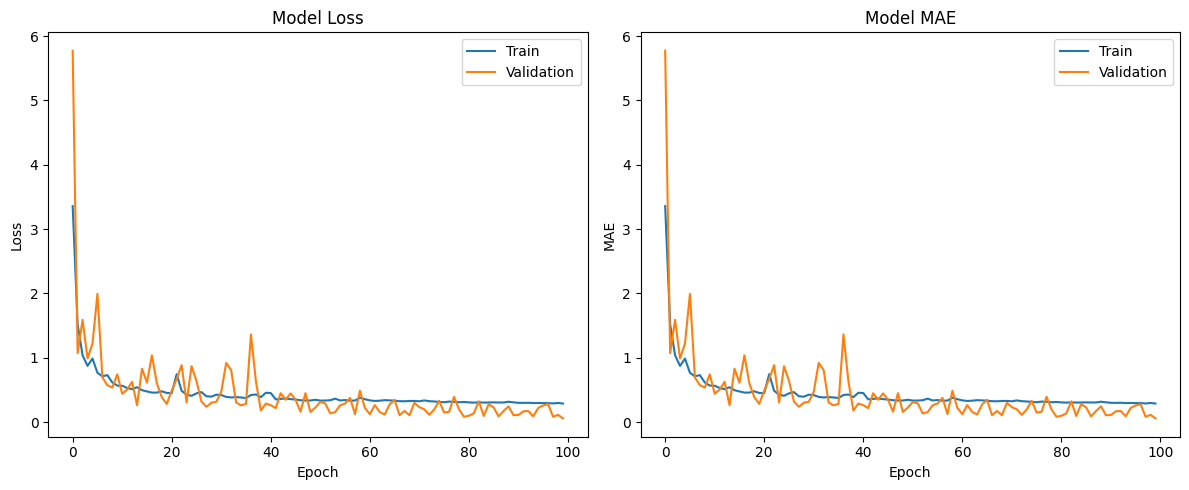

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')     
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation metric values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
from tensorflow import lite

ckp_path = r"D:\SignLanguage\SL_RECOG\trained_model\model.weights.h5"
model.load_weights(ckp_path)

converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
    
with open ("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cloud\AppData\Local\Temp\tmp5bis1bn9\assets


INFO:tensorflow:Assets written to: C:\Users\cloud\AppData\Local\Temp\tmp5bis1bn9\assets


Saved artifact at 'C:\Users\cloud\AppData\Local\Temp\tmp5bis1bn9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_486')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2808956146560: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2808909575296: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2808956445520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808956444288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808956447456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808956440064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808956446048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808956450624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808957046624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2808957044512: TensorSpec(shape=(), dtype=tf.resource

In [1]:
import numpy as np
import cv2
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (96, 96))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict(image_path):
    input_data = preprocess_image(image_path)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data[0][0]

In [6]:
# Example usage
image_path = "./300_DS/A/LEFT_C_13.jpg"
prediction = predict(image_path)
print(f"Predicted value: {prediction}")

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

predicted_label = labels[int(round(prediction))]
print(f"Predicted label: {predicted_label}")

Predicted value: 1.0860812664031982
Predicted label: 1
